In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import mutagenesis_functions as mf
import time as time

In [3]:
# load hairpin data
data_path = 'data_peter/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}




In [14]:
len(train['inputs'])

192000

In [23]:
input_shape[1]-29

12

In [4]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    layer4 = {'layer': 'conv1d',
            'num_filters': 196,
            'filter_size': 3,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.5,
            'padding': 'VALID',
            }
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = 'results/trial'
param_path = os.path.join(save_path, 'hairpin')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [25]:
output_shape[1]

1

In [5]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: conv1d_1
(?, 1, 1, 196)
layer17: conv1d_1_batch
(?, 1, 1, 196)
layer18: conv1d_1_active
(?, 1, 1, 196)
layer19: conv1d_1_dropout


In [6]:
# initialize session
sess = utils.initialize_session()

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

#Get Predictions

# calculate activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
predictionslogits = nntrainer.get_activations(sess, test, layer='dense_0_bias')

loading model from:  results/trial/hairpin_best.ckpt
INFO:tensorflow:Restoring parameters from results/trial/hairpin_best.ckpt


# Average the second order mutagenesis scores for 1000 different sequences

Since each mutagenesis produces 41*41*16 = 26896 sequences, getting scores for 1000 is gonna take a long time...

In [8]:
# sort activations
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

In [44]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_summary = 100

sum_mut2_predictoutputs = np.zeros((41*41*16, 1))
starttime = time.time()

for ii in range(num_summary):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get output activations for the mutations
    mut2_predictoutputs= nntrainer.get_activations(sess, mutations, layer='output')
    
    #Sum all the scores into a single matrix
    sum_mut2_predictoutputs += mut2_predictoutputs
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()
    


loading model from:  results/trial/hairpin_best.ckpt
INFO:tensorflow:Restoring parameters from results/trial/hairpin_best.ckpt
0
Epoch duration =9.51s
Cumulative duration =9.51s

1
Epoch duration =8.98s
Cumulative duration =18.5s

2
Epoch duration =9.02s
Cumulative duration =27.52s

3
Epoch duration =8.94s
Cumulative duration =36.46s

4
Epoch duration =9.09s
Cumulative duration =45.55s

5
Epoch duration =9.01s
Cumulative duration =54.56s

6
Epoch duration =8.89s
Cumulative duration =63.45s

7
Epoch duration =8.95s
Cumulative duration =72.4s

8
Epoch duration =9.01s
Cumulative duration =81.41s

9
Epoch duration =9.05s
Cumulative duration =90.46s

10
Epoch duration =9.09s
Cumulative duration =99.55s

11
Epoch duration =9.08s
Cumulative duration =108.63s

12
Epoch duration =9.11s
Cumulative duration =117.74s

13
Epoch duration =8.94s
Cumulative duration =126.68s

14
Epoch duration =9.45s
Cumulative duration =136.13s

15
Epoch duration =10.23s
Cumulative duration =146.37s

16
Epoch duratio

In [49]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

#num_summary = 100

#sum_mut2_predictoutputs = np.zeros((41*41*16, 1))
starttime = time.time()

for ii in range(100,1000):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get output activations for the mutations
    mut2_predictoutputs= nntrainer.get_activations(sess, mutations, layer='output')
    
    #Sum all the scores into a single matrix
    sum_mut2_predictoutputs += mut2_predictoutputs
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()
    


loading model from:  results/trial/hairpin_best.ckpt
INFO:tensorflow:Restoring parameters from results/trial/hairpin_best.ckpt
100
Epoch duration =9.13s
Cumulative duration =9.13s

101
Epoch duration =8.78s
Cumulative duration =17.91s

102
Epoch duration =9.06s
Cumulative duration =26.97s

103
Epoch duration =8.88s
Cumulative duration =35.85s

104
Epoch duration =8.92s
Cumulative duration =44.76s

105
Epoch duration =10.16s
Cumulative duration =54.93s

106
Epoch duration =9.18s
Cumulative duration =64.11s

107
Epoch duration =8.79s
Cumulative duration =72.9s

108
Epoch duration =8.94s
Cumulative duration =81.84s

109
Epoch duration =8.81s
Cumulative duration =90.66s

110
Epoch duration =9.02s
Cumulative duration =99.68s

111
Epoch duration =8.73s
Cumulative duration =108.41s

112
Epoch duration =8.91s
Cumulative duration =117.32s

113
Epoch duration =9.43s
Cumulative duration =126.75s

114
Epoch duration =8.91s
Cumulative duration =135.66s

115
Epoch duration =8.78s
Cumulative duration

Epoch duration =9.03s
Cumulative duration =1312.51s

245
Epoch duration =8.98s
Cumulative duration =1321.49s

246
Epoch duration =8.94s
Cumulative duration =1330.43s

247
Epoch duration =8.84s
Cumulative duration =1339.27s

248
Epoch duration =8.92s
Cumulative duration =1348.19s

249
Epoch duration =8.88s
Cumulative duration =1357.07s

250
Epoch duration =8.98s
Cumulative duration =1366.06s

251
Epoch duration =8.86s
Cumulative duration =1374.92s

252
Epoch duration =8.95s
Cumulative duration =1383.87s

253
Epoch duration =8.87s
Cumulative duration =1392.74s

254
Epoch duration =9.0s
Cumulative duration =1401.74s

255
Epoch duration =8.87s
Cumulative duration =1410.61s

256
Epoch duration =8.89s
Cumulative duration =1419.51s

257
Epoch duration =8.9s
Cumulative duration =1428.41s

258
Epoch duration =8.85s
Cumulative duration =1437.25s

259
Epoch duration =8.99s
Cumulative duration =1446.25s

260
Epoch duration =8.87s
Cumulative duration =1455.12s

261
Epoch duration =8.9s
Cumulative d

Epoch duration =8.87s
Cumulative duration =2611.67s

390
Epoch duration =8.87s
Cumulative duration =2620.53s

391
Epoch duration =8.83s
Cumulative duration =2629.37s

392
Epoch duration =8.98s
Cumulative duration =2638.34s

393
Epoch duration =9.1s
Cumulative duration =2647.44s

394
Epoch duration =8.85s
Cumulative duration =2656.28s

395
Epoch duration =8.85s
Cumulative duration =2665.13s

396
Epoch duration =8.83s
Cumulative duration =2673.97s

397
Epoch duration =8.89s
Cumulative duration =2682.86s

398
Epoch duration =8.81s
Cumulative duration =2691.66s

399
Epoch duration =8.83s
Cumulative duration =2700.49s

400
Epoch duration =8.85s
Cumulative duration =2709.34s

401
Epoch duration =8.82s
Cumulative duration =2718.16s

402
Epoch duration =8.96s
Cumulative duration =2727.13s

403
Epoch duration =8.85s
Cumulative duration =2735.98s

404
Epoch duration =8.85s
Cumulative duration =2744.82s

405
Epoch duration =8.84s
Cumulative duration =2753.66s

406
Epoch duration =8.88s
Cumulative

Epoch duration =8.77s
Cumulative duration =3898.89s

535
Epoch duration =9.02s
Cumulative duration =3907.91s

536
Epoch duration =8.83s
Cumulative duration =3916.74s

537
Epoch duration =8.92s
Cumulative duration =3925.66s

538
Epoch duration =8.85s
Cumulative duration =3934.51s

539
Epoch duration =8.93s
Cumulative duration =3943.45s

540
Epoch duration =8.8s
Cumulative duration =3952.24s

541
Epoch duration =8.78s
Cumulative duration =3961.03s

542
Epoch duration =8.8s
Cumulative duration =3969.83s

543
Epoch duration =8.77s
Cumulative duration =3978.6s

544
Epoch duration =8.79s
Cumulative duration =3987.39s

545
Epoch duration =8.77s
Cumulative duration =3996.16s

546
Epoch duration =8.77s
Cumulative duration =4004.93s

547
Epoch duration =8.79s
Cumulative duration =4013.72s

548
Epoch duration =8.8s
Cumulative duration =4022.52s

549
Epoch duration =8.77s
Cumulative duration =4031.29s

550
Epoch duration =8.85s
Cumulative duration =4040.14s

551
Epoch duration =8.8s
Cumulative dur

Epoch duration =8.87s
Cumulative duration =5186.46s

680
Epoch duration =8.91s
Cumulative duration =5195.37s

681
Epoch duration =8.84s
Cumulative duration =5204.21s

682
Epoch duration =8.85s
Cumulative duration =5213.06s

683
Epoch duration =8.85s
Cumulative duration =5221.91s

684
Epoch duration =8.95s
Cumulative duration =5230.86s

685
Epoch duration =11.13s
Cumulative duration =5241.99s

686
Epoch duration =9.84s
Cumulative duration =5251.83s

687
Epoch duration =9.34s
Cumulative duration =5261.17s

688
Epoch duration =8.89s
Cumulative duration =5270.06s

689
Epoch duration =8.91s
Cumulative duration =5278.97s

690
Epoch duration =8.88s
Cumulative duration =5287.85s

691
Epoch duration =8.9s
Cumulative duration =5296.75s

692
Epoch duration =8.84s
Cumulative duration =5305.59s

693
Epoch duration =8.86s
Cumulative duration =5314.45s

694
Epoch duration =8.83s
Cumulative duration =5323.28s

695
Epoch duration =8.81s
Cumulative duration =5332.09s

696
Epoch duration =8.85s
Cumulativ

Epoch duration =8.86s
Cumulative duration =6481.21s

825
Epoch duration =8.89s
Cumulative duration =6490.1s

826
Epoch duration =8.82s
Cumulative duration =6498.92s

827
Epoch duration =8.81s
Cumulative duration =6507.73s

828
Epoch duration =8.8s
Cumulative duration =6516.53s

829
Epoch duration =8.82s
Cumulative duration =6525.35s

830
Epoch duration =8.82s
Cumulative duration =6534.17s

831
Epoch duration =8.8s
Cumulative duration =6542.97s

832
Epoch duration =8.9s
Cumulative duration =6551.87s

833
Epoch duration =8.8s
Cumulative duration =6560.67s

834
Epoch duration =8.78s
Cumulative duration =6569.45s

835
Epoch duration =8.85s
Cumulative duration =6578.29s

836
Epoch duration =8.75s
Cumulative duration =6587.05s

837
Epoch duration =8.77s
Cumulative duration =6595.82s

838
Epoch duration =8.81s
Cumulative duration =6604.63s

839
Epoch duration =8.78s
Cumulative duration =6613.41s

840
Epoch duration =8.81s
Cumulative duration =6622.21s

841
Epoch duration =8.77s
Cumulative dur

Epoch duration =8.76s
Cumulative duration =7758.6s

970
Epoch duration =8.77s
Cumulative duration =7767.37s

971
Epoch duration =8.74s
Cumulative duration =7776.11s

972
Epoch duration =8.82s
Cumulative duration =7784.93s

973
Epoch duration =8.76s
Cumulative duration =7793.69s

974
Epoch duration =8.78s
Cumulative duration =7802.47s

975
Epoch duration =8.8s
Cumulative duration =7811.26s

976
Epoch duration =8.86s
Cumulative duration =7820.13s

977
Epoch duration =8.77s
Cumulative duration =7828.9s

978
Epoch duration =8.79s
Cumulative duration =7837.69s

979
Epoch duration =8.76s
Cumulative duration =7846.45s

980
Epoch duration =8.79s
Cumulative duration =7855.24s

981
Epoch duration =8.8s
Cumulative duration =7864.04s

982
Epoch duration =8.78s
Cumulative duration =7872.82s

983
Epoch duration =8.82s
Cumulative duration =7881.64s

984
Epoch duration =9.23s
Cumulative duration =7890.87s

985
Epoch duration =8.76s
Cumulative duration =7899.63s

986
Epoch duration =8.78s
Cumulative du

In [50]:
mean_mut2_predictoutputs = sum_mut2_predictoutputs/1000

In [51]:
#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_predictoutputs_hol = mean_mut2_predictoutputs.reshape(X.shape[1],X.shape[1],4,4)

In [53]:
#save the summed mutations data to a file
npy_save_path = 'sum_mut2_predictoutputs1000.npy'
np.save(npy_save_path, sum_mut2_predictoutputs)

### Signatures

###### Based pairs

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


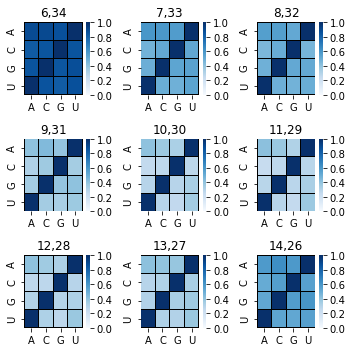

In [52]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(5,5))

num = 9

for ii in range(9):
    ax = fig4.add_subplot(3,3,ii+1)
    ax.set_title(str(6+ii)+','+str(34-ii))
    ax = sb.heatmap(mean_mut2_predictoutputs_hol[6+ii, 34-ii], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)



###### First 20

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


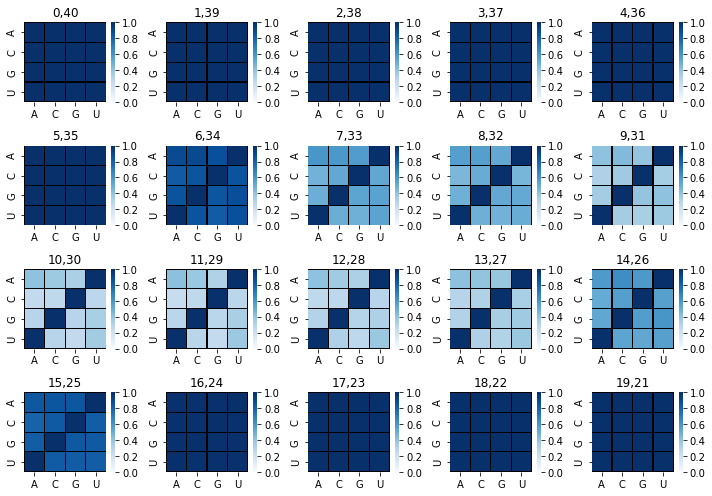

In [57]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(10,7))

num = 20

for ii in range(num):
    ax = fig4.add_subplot(4,5,ii+1)
    ax.set_title(str(ii)+','+str(40-ii))
    ax = sb.heatmap(mean_mut2_predictoutputs_hol[ii, 40-ii], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)




###### All base Paired

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


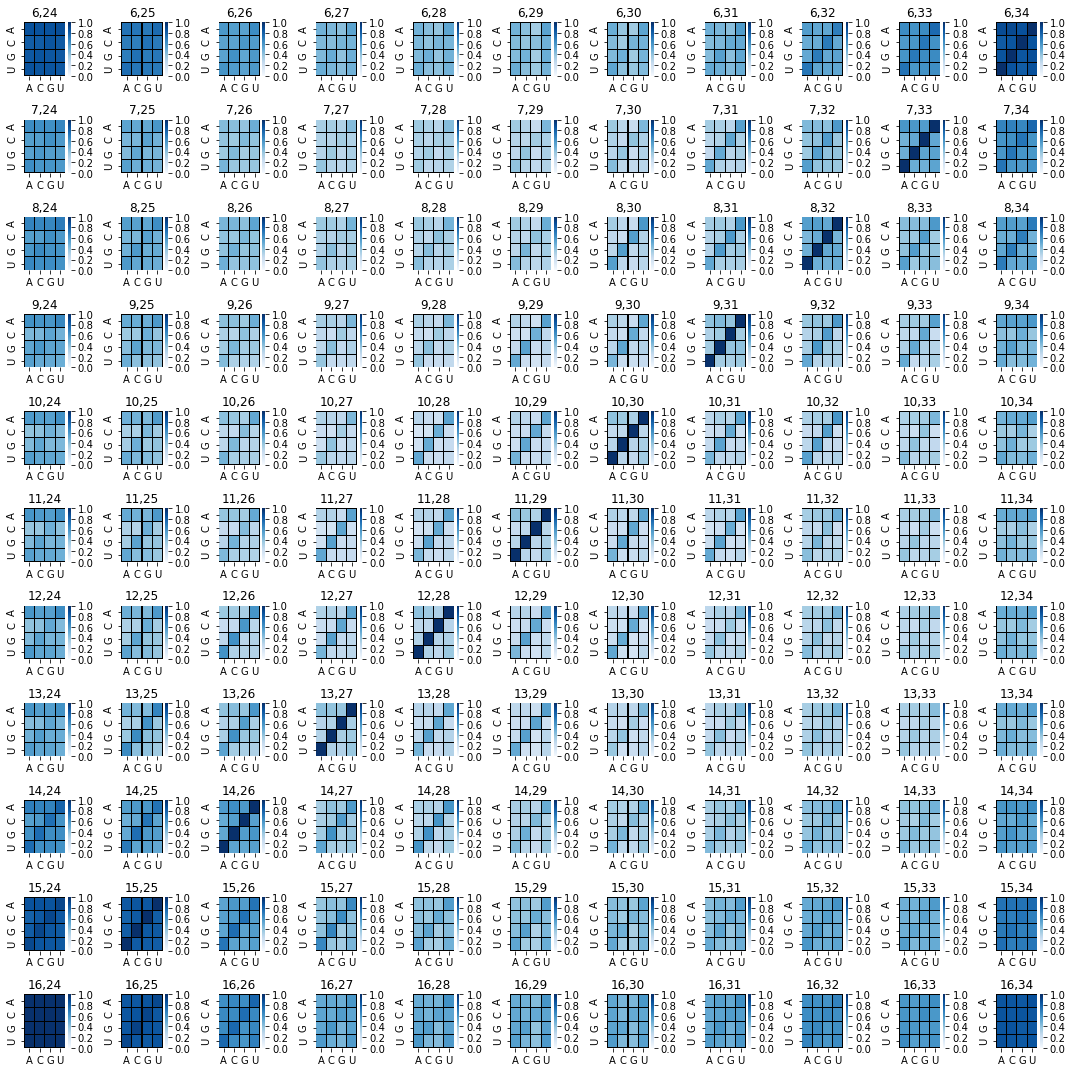

In [70]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,15))

num = 11

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        ax.set_title(str(one+6)+','+str(two+24))
        ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)


        

###### All base Paired (editted visuals)

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


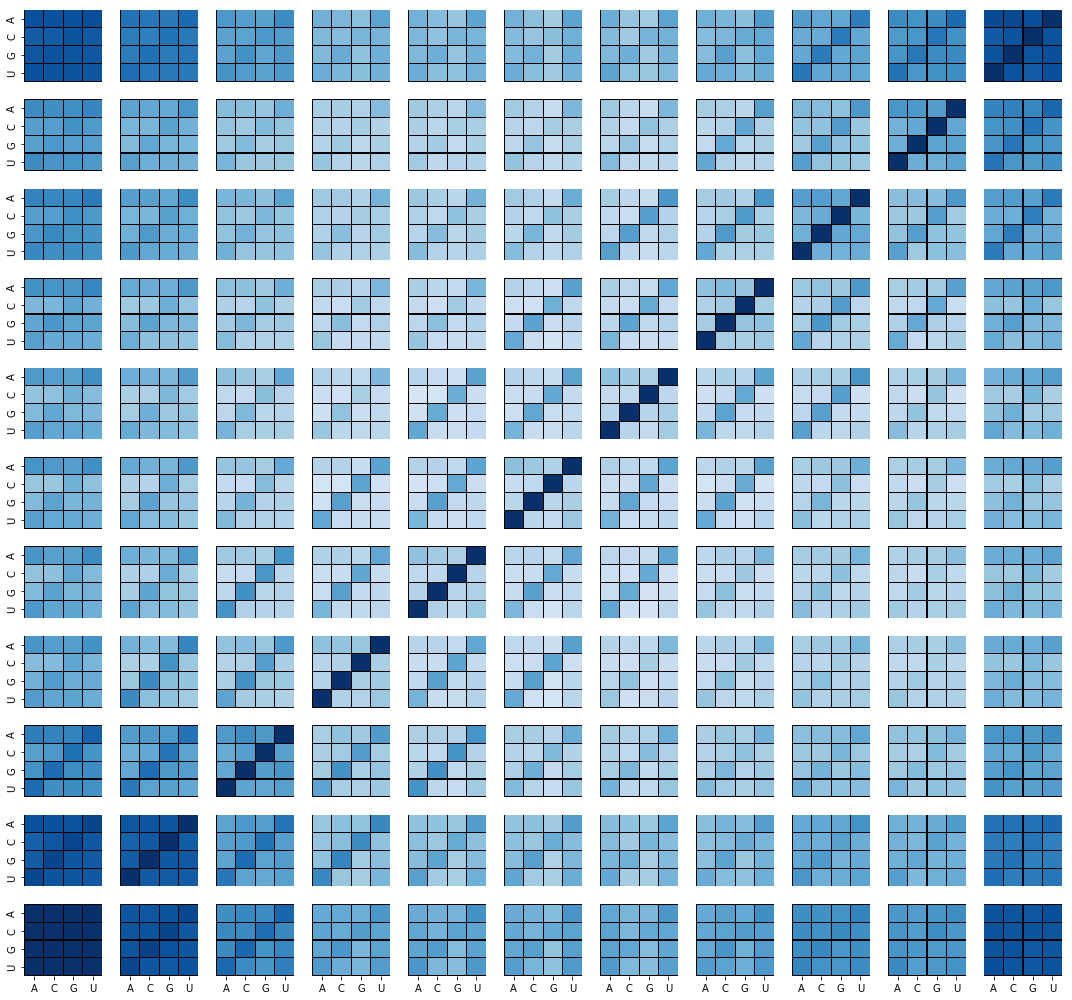

In [74]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,14))

num = 11

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        
        #plot the 0th column with row labels and the num_th most row with column labels
        if two == 0:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc, cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=nuc, cbar=False)
        else:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=[], cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=[], cbar=False)




        

###### Single Pair

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


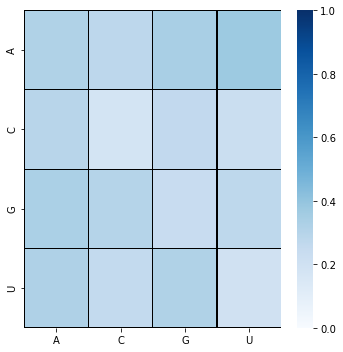

In [62]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(5,5))

ii1 = 11
ii2 = 12
ax.set_title(str(ii1)+','+str(ii2))
ax = sb.heatmap(mean_mut2_predictoutputs_hol[ii1, ii2], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)


In [1]:
#Perform some sort of summary along the dims axis to plot in a heatmap

mut2_predictoutputs = mean_mut2_predictoutputs 

#Reshape into its organization L*L*mutations
mut2_predictoutputs = mut2_predictoutputs.reshape(X.shape[1],X.shape[1],16)

#Summarize the data in some way
mut2_sumoutputs = np.sqrt(np.sum(mut2_predictoutputs**2, axis=2))
mut2_stdoutputs = np.std(mut2_predictoutputs, axis=2)
mut2_maxoutputs = np.max(mut2_predictoutputs, axis=2)


#Plot heatmaps of the data
plt.figure(figsize=(20,12))

#Plot all of the data
zoom1 = 0
zoom2 = X.shape[1]

plt.subplot(221)
plt.title('Summary: squared sum of mutation prediction scores')
sb.heatmap(mut2_sumoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')
plt.subplot(222)
plt.title('Summary: standard deviation of mutation prediction scores')
sb.heatmap(mut2_stdoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')
plt.subplot(223)
plt.title('Summary: maximum score across mutations combinations')
sb.heatmap(mut2_maxoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')

NameError: name 'mean_mut2_predictoutputs' is not defined

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


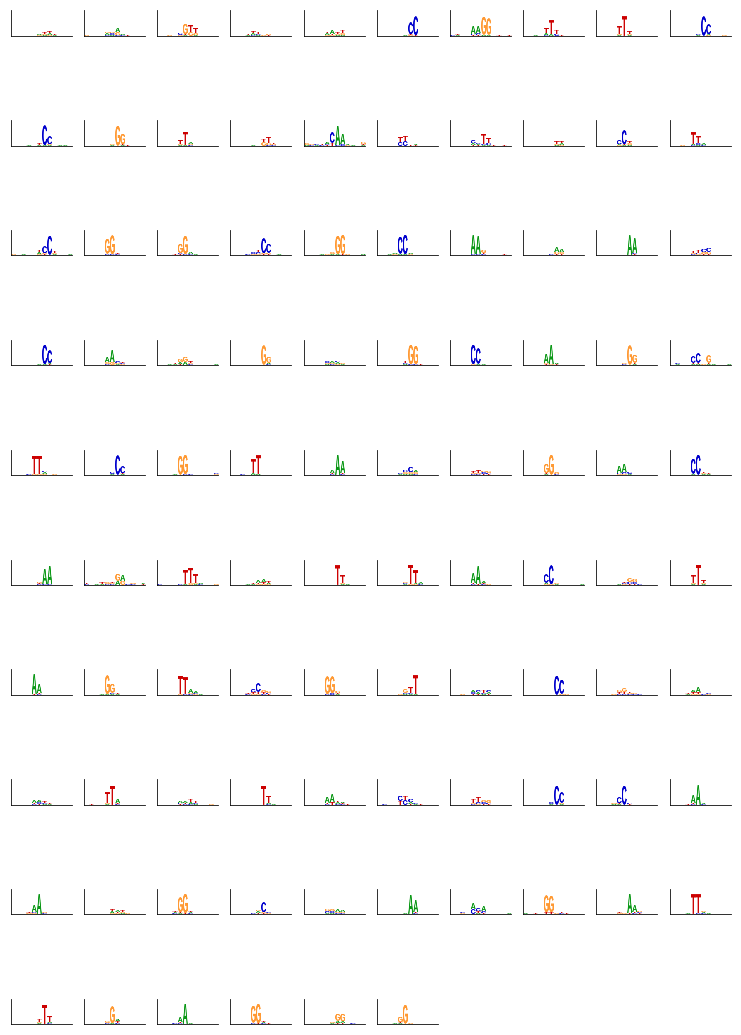

In [18]:
# plot first layer filters
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]
fig = visualize.plot_filter_logos(W, figsize=(100,150), height=25, 
                            nt_width=10, norm=0, alphabet='dna')

In [34]:
# plot first layer filters
W = nnmodel.get_parameters(sess, layer='conv1d_0_batch')[0]
np.shape(W)

(2, 96)